In [288]:
import tensorflow as tf
import pandas as pd
import numpy as np
from pandas import Series, DataFrame
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


In [289]:
menu= pd.read_csv("TSMC_data.csv",usecols=[2,4,6,8])
menu.head()

,Open_,High_,Low_,CC
0,NaN,NaN,NaN,NaN
1,0.029713,0.021021,0.029866,1.4
2,0.000000,-0.004902,0.000000,0.5
3,0.004975,-0.004926,-0.009000,-1.0
4,-0.013861,-0.009901,-0.002018,-0.8


In [290]:
menu=menu.dropna(axis='rows',how='all')
menu.shape

(1133, 4)

## inputs data

In [291]:
def create_dataset(dataset, look_back=1):

    dataX, dataY = [], []
    
    for i in range(len(dataset)-look_back+1):
            dataX.append(dataset[i:(i+look_back),:])
            dataY.append(dataset[i+look_back-1,:])

    return np.array(dataX), np.array(dataY)

In [292]:
look_back=5
col=3

In [293]:
x=pd.concat([menu.Open_, menu.High_, menu.Low_],axis=1)
x.shape

(1133, 3)

In [294]:
x=x.values
scaler = MinMaxScaler(feature_range=(0,1))
x= scaler.fit_transform(x)
x_data,n_n=create_dataset(x,look_back)
x_data.shape

(1129, 5, 3)

In [295]:
train_size= int(len(x_data)*0.8)
test_size= len(x_data)-train_size

In [296]:
x_train,x_test= x_data[0:train_size,:],x_data[train_size:len(x_data),:]

print(x_train)
print(x_train.shape,x_test.shape)

[[[ 0.75050888  0.73042342  0.76065176]
  [ 0.53825358  0.53696069  0.53373342]
  [ 0.57379332  0.53678048  0.46535275]
  [ 0.43923492  0.49965303  0.51839971]
  [ 0.60280318  0.61085884  0.55678049]]

 [[ 0.53825358  0.53696069  0.53373342]
  [ 0.57379332  0.53678048  0.46535275]
  [ 0.43923492  0.49965303  0.51839971]
  [ 0.60280318  0.61085884  0.55678049]
  [ 0.49560588  0.61067319  0.5567108 ]]

 [[ 0.57379332  0.53678048  0.46535275]
  [ 0.43923492  0.49965303  0.51839971]
  [ 0.60280318  0.61085884  0.55678049]
  [ 0.49560588  0.61067319  0.5567108 ]
  [ 0.65266381  0.61048938  0.61009374]]

 ..., 
 [[ 0.53825358  0.61582711  0.64289796]
  [ 0.55849009  0.63661138  0.53373342]
  [ 0.679509    0.82369973  0.68439904]
  [ 0.6174058   0.55337371  0.63925914]
  [ 0.47953997  0.43196976  0.40883722]]

 [[ 0.55849009  0.63661138  0.53373342]
  [ 0.679509    0.82369973  0.68439904]
  [ 0.6174058   0.55337371  0.63925914]
  [ 0.47953997  0.43196976  0.40883722]
  [ 0.38038642  0.4910800

In [297]:
x_train=np.reshape(x_train, (-1, look_back*col))
x_test=np.reshape(x_test,(-1, look_back*col))
print(x_train.shape, x_test.shape)

(903, 15) (226, 15)


In [298]:
y=pd.concat([menu.CC],axis=1)
y=y.values
print (len(y))

1133


In [299]:
def markupdown(dataset):
    ar=[]
    for i in range (len(y)):
        #print(y[i])
        if y[i]<0:
            ar.append([1,0])
        else:
            ar.append([0,1])
        #print('ar= ',ar)
    return np.array(ar)

In [300]:
y_data= markupdown(y)
y_data=y_data[4:len(y_data),:]
y_train,y_test= y_data[0:train_size,:],y_data[train_size:len(y_data),:]
print(y_train.shape, y_test.shape)

(903, 2) (226, 2)


## train model

In [301]:
def layer(output_dim,input_dim,inputs,activation):
    w=tf.Variable(tf.random_normal([input_dim,output_dim]))
    b=tf.Variable(tf.random_normal([1,output_dim]))
    xwb=tf.matmul(inputs,w)+b
    if activation is None:
        outputs=xwb
    else:
        outputs=activation(xwb)
    return outputs

In [302]:
x=tf.placeholder("float",[None,look_back*col])
h1=layer(output_dim=40, input_dim=look_back*col, inputs=x, activation=tf.nn.relu)
#h2=layer(output_dim=10, input_dim=80, inputs=h1,activation=tf.nn.relu)
y_predict=layer(output_dim=2, input_dim=40, inputs=h1, activation=None)

In [303]:
y_label=tf.placeholder("float",[None,2])
loss_fun=tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=y_predict, labels=y_label))
optimizer=tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss_fun)

In [304]:
correct_predict=tf.equal(tf.argmax(y_label,1),tf.argmax(y_predict,1))
accuracy= tf.reduce_mean(tf.cast(correct_predict,"float"))

## training

In [305]:
trainEpochs=500
batchsize=100
totalbatchs= int(len(x_data)//batchsize)

loss_train=[];epoch_list=[];accuracy_train=[]
loss_test=[]; accuracy_test=[]
from time import time
startTime=time()

sess=tf.Session()
sess.run(tf.global_variables_initializer())

In [306]:
predict=[]
for epoch in range(trainEpochs):
    shuffle = np.random.permutation(len(y_train)-1)
    x_train = x_train[shuffle]
    y_train = y_train[shuffle]
    for i in range(totalbatchs):
        sess.run(optimizer,feed_dict={x:x_train,y_label:y_train})
        
    
    loss_tra,acc_tra= sess.run([loss_fun, accuracy],feed_dict={x:x_train,y_label:y_train})
    loss_t,acc_t= sess.run([loss_fun, accuracy],feed_dict={x:x_test,y_label:y_test})
    

    epoch_list.append(epoch);
    loss_test.append(loss_t)
    loss_train.append(loss_tra)
    accuracy_test.append(acc_t)
    accuracy_train.append(acc_tra)
    
    
    #print ("Train Epoch:",'%02d'%(epoch+1),"Loss=","{:.9f}".format(loss),"Accuracy=",acc)

duration=time()-startTime

print("Loss_train= ",loss_tra)
print ("Loss_test= ",loss_t)

print("Accuracy_train= ", acc_tra)
print("Accuracy_test= ", acc_t)

print("Train Finished takes:",duration)

Loss_train=  0.264621
Loss_test=  0.431917
Accuracy_train=  0.878412
Accuracy_test=  0.761062
Train Finished takes: 5.671633958816528


## plot

In [307]:
%matplotlib inline
import matplotlib.pyplot as plt

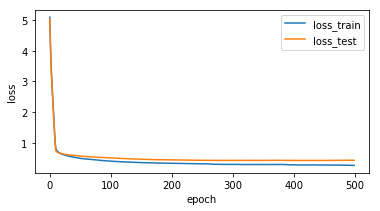

In [308]:
fig=plt.gcf()
fig.set_size_inches(6,3)
plt.plot(epoch_list,loss_train, label='loss_train')
plt.plot(epoch_list,loss_test, label='loss_test')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

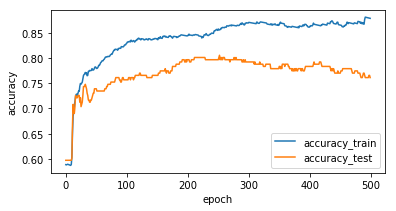

In [309]:
fig=plt.gcf()
fig.set_size_inches(6,3)
plt.plot(epoch_list,accuracy_train, label='accuracy_train')
plt.plot(epoch_list,accuracy_test, label='accuracy_test')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()